In [ ]:
# 드라이브에 접근할 수 있도록 아래 코드 입력
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 무비렌즈 데이터
+ 추천 시스템에 사용될 모델 학습에선 데이터가 필수!
+ 무비렌즈 데이터를 추천 모델 학습에 필요한 형태로 `가공`해봄

## 랭킹(Ranking)

+ 유저에게 적합한 아이템 Top K개를 추천
+ Top K개를 선정하기 위한 기준 혹은 `Score`가 필요하지만, 유저`X`가 아이템 `Y`에 가지는 **정확한 선호도를 구할 필요 X**<br>
_평가 지표 : Precision@K, Recall@K, MAP@K, nDCG@K_


## 데이터 특징
+ 유저가 영화에게 준 평점 데이터가 있음
+ 영화에 대한 제목, 장르, 연도 등이 있음
+ 유저에 대한 성별, 연령, 직업, 주소 등이 있음
+ **Explicit Feedback** : 선호도 1.0 ~ 5.0 사이의 점수로 표현

### 헤더 선언

In [ ]:
import os
import pandas as pd
import seaborn as sns
import numpy as np
import random
from matplotlib import pyplot as plt
from datetime import datetime
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

### 데이터 초기화

In [ ]:
path = '/content/drive/MyDrive/Colab_Notebook/learning_spoons_recommendation_system/data/ml-100k/' # '/data/ml-100k'

ratings_df = pd.read_csv(path + 'u.data', sep='\t', encoding='latin-1', header=None)
movies_df = pd.read_csv(path + 'u.item', sep='|', encoding='latin-1', header=None)
users_df = pd.read_csv(path + 'u.user', sep='|', encoding='latin-1', header=None)

ratings_df.columns = ['user_id', 'movie_id', 'rating', 'timestamp']
movies_df.columns =  ['movie_id', 'movie_title', 'release_date', 'video_release_date',
                     'IMDb_URL', 'unknown', 'Action', 'Adventure', 'Animation', 
                     'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy',
                     'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi',
                     'Thriller', 'War', 'Western']
users_df.columns = ['user_id', 'age', 'gender', 'occupation', 'zip_code']

+ timestamp를 datetime으로 변경!
+ 추천 문제에서 보통 과거 데이터를 `학습`해서 현재, 미래에 추천하기 때문에 `시간`은 **트레이닝 데이터와 테스트 데이터를 나눌 때** 매우 중요

In [ ]:
ratings_df['datetime'] = pd.to_datetime(ratings_df['timestamp'], unit='s')
ratings_df['date'] = ratings_df['datetime'].dt.strftime('%Y-%m-%d').astype(str)

### 평점 데이터의 기초 통계량


+ 데이터에 대한 기본적인 통계 정보를 확인
+ 몇가지 정보에 대해서 `Visualization`

In [ ]:
n_user = len(ratings_df['user_id'].unique())    # 유저 수
n_movie = len(ratings_df['movie_id'].unique())    # 영화 수

print('유저 수 :', n_user, '영화 수 :', n_movie)

# 평점 데이터 정보
ratings_df.info()

유저 수 : 943 영화 수 : 1682
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   user_id    100000 non-null  int64         
 1   movie_id   100000 non-null  int64         
 2   rating     100000 non-null  int64         
 3   timestamp  100000 non-null  int64         
 4   datetime   100000 non-null  datetime64[ns]
 5   date       100000 non-null  object        
dtypes: datetime64[ns](1), int64(4), object(1)
memory usage: 4.6+ MB


In [ ]:
# pandas에서 제공하는 기초 통계량, 열 이름 잘못 적으면 오류!
ratings_df[['user_id', 'movie_id', 'rating']].describe()

,user_id,movie_id,rating
count,100000.00000,100000.000000,100000.000000
mean,462.48475,425.530130,3.529860
std,266.61442,330.798356,1.125674
min,1.00000,1.000000,1.000000
25%,254.00000,175.000000,3.000000
50%,447.00000,322.000000,4.000000
75%,682.00000,631.000000,4.000000
max,943.00000,1682.000000,5.000000


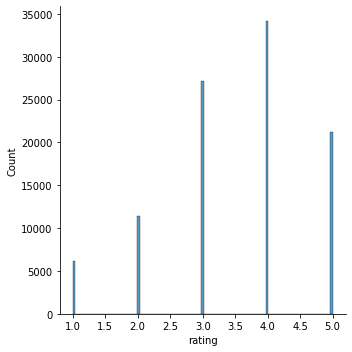

In [ ]:
# 평점 데이터 분포
sns.displot(ratings_df['rating'])

In [ ]:
# 사용자 별로 aggregate한 데이터 확인
user_stastics = pd.DataFrame({
    'numRating' : ratings_df.groupby('user_id')['movie_id'].nunique(),
    'avgRating' : ratings_df.groupby('user_id')['movie_id'].mean(),
    'stdRating' : ratings_df.groupby('user_id')['movie_id'].std(),
}).reset_index()

user_stastics.head()

,user_id,numRating,avgRating,stdRating
0,1,272,136.500000,78.663842
1,2,62,249.500000,93.021194
2,3,54,318.814815,33.955061
3,4,24,291.041667,90.440218
4,5,175,291.291429,140.223880


================사용자의 평점 분포=================
=============사용자의 평가 영화 개수 분포==============


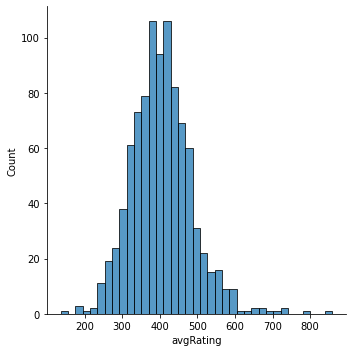

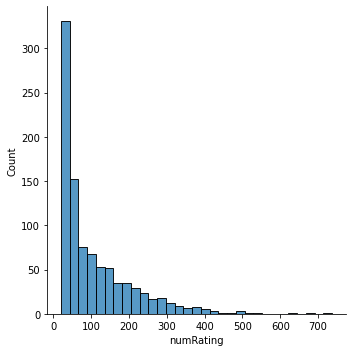

In [ ]:
# 사용자의 평점 분포
# print('{0:=^43}'.format('사용자의 평점 분포'))
sns.displot(user_stastics['avgRating'])

# 사용자 평가 영화 개수 분포
sns.displot(user_stastics['numRating'])

### 인기도 기반 영화 추천(Popular, Highly Rated)

+ Popular : 가장 많은 유저가 본 영화(혹은 평가를 받은)
+ Highly Rated : 가장 높은 평점을 받은 영화

In [ ]:
# 영화 Ranking을 위한 영화별 통계량 계산

movie_statistics = pd.DataFrame({
    'numUsers': ratings_df.groupby('movie_id')['user_id'].nunique(),
    'avgRating': ratings_df.groupby('movie_id')['rating'].mean(), 
    'stdRating': ratings_df.groupby('movie_id')['rating'].std()
}).reset_index()

movie_statistics.head()

,movie_id,numUsers,avgRating,stdRating
0,1,452,3.878319,0.927897
1,2,131,3.206107,0.966497
2,3,90,3.033333,1.212760
3,4,209,3.550239,0.965069
4,5,86,3.302326,0.946446


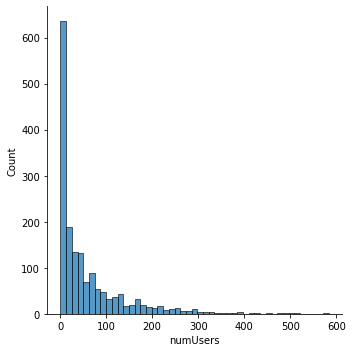

In [ ]:
# 영화별 평가 개수 분포
sns.displot(movie_statistics['numUsers'])

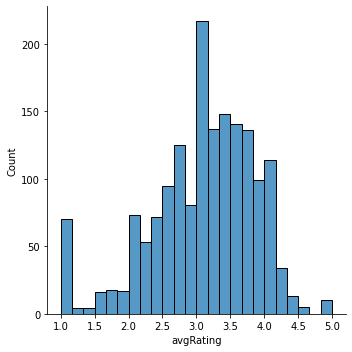

In [ ]:
# 영화별 평균 평점의 분포
sns.displot(movie_statistics['avgRating'])

### Popular


In [ ]:
# 가장 많은 유저가 본 영화 Top 10
top10_df = movie_stastics.sort_values(by='numUsers', ascending=False)[:10]
pd.merge(top10_df, movies_df[['movie_id', 'movie_title', 'release_date']], how='inner', on='movie_id')

,movie_id,numUsers,avgRating,stdRating,movie_title,release_date
0,50,583,4.358491,0.881341,Star Wars (1977),01-Jan-1977
1,258,509,3.803536,0.994427,Contact (1997),11-Jul-1997
2,100,508,4.155512,0.975756,Fargo (1996),14-Feb-1997
3,181,507,4.007890,0.923955,Return of the Jedi (1983),14-Mar-1997
4,294,485,3.156701,1.098544,Liar Liar (1997),21-Mar-1997
5,286,481,3.656965,1.169401,"English Patient, The (1996)",15-Nov-1996
6,288,478,3.441423,1.113910,Scream (1996),20-Dec-1996
7,1,452,3.878319,0.927897,Toy Story (1995),01-Jan-1995
8,300,431,3.631090,0.998072,Air Force One (1997),01-Jan-1997
9,121,429,3.438228,1.116584,Independence Day (ID4) (1996),03-Jul-1996


### Highly Rated

In [ ]:
# 평점이 가장 높은 영화 Top 10
top10_df = movie_statistics.sort_values(by='avgRating', ascending=False)[:10]
pd.merge(top10_df, movies_df[['movie_id', 'movie_title', 'release_date']], how='inner', on='movie_id')

,movie_id,numUsers,avgRating,stdRating,movie_title,release_date
0,814,1,5.0,NaN,"Great Day in Harlem, A (1994)",01-Jan-1994
1,1599,1,5.0,NaN,Someone Else's America (1995),10-May-1996
2,1201,1,5.0,NaN,Marlene Dietrich: Shadow and Light (1996),02-Apr-1996
3,1122,1,5.0,NaN,They Made Me a Criminal (1939),01-Jan-1939
4,1653,1,5.0,NaN,Entertaining Angels: The Dorothy Day Story (1996),27-Sep-1996
5,1293,3,5.0,0.0,Star Kid (1997),16-Jan-1998
6,1500,2,5.0,0.0,Santa with Muscles (1996),08-Nov-1996
7,1189,3,5.0,0.0,Prefontaine (1997),24-Jan-1997
8,1536,1,5.0,NaN,Aiqing wansui (1994),22-Jul-1996
9,1467,2,5.0,0.0,"Saint of Fort Washington, The (1993)",01-Jan-1993


### Steam Rating

+ `Steam Rating Fomular`를 활용한 평균 평점

In [ ]:
movie_statistics['steamRating'] = movie_statistics['avgRating'] - (movie_statistics['avgRating'] - 3.0) \
                                  * np.power(2, -np.log10(movie_statistics['numUsers']))
top10_df = movie_statistics.sort_values(by = 'steamRating', ascending=False)[:10]
pd.merge(top10_df, movies_df[['movie_id', 'movie_title', 'release_date']], how='inner', on ='movie_id')


,movie_id,numUsers,avgRating,stdRating,steamRating,movie_title,release_date
0,318,298,4.466443,0.829109,4.202535,Schindler's List (1993),01-Jan-1993
1,64,283,4.445230,0.767008,4.181064,"Shawshank Redemption, The (1994)",01-Jan-1994
2,483,243,4.456790,0.728114,4.178012,Casablanca (1942),01-Jan-1942
3,50,583,4.358491,0.881341,4.158731,Star Wars (1977),01-Jan-1977
4,408,112,4.491071,0.771047,4.130806,"Close Shave, A (1995)",28-Apr-1996
5,12,267,4.385768,0.825500,4.127995,"Usual Suspects, The (1995)",14-Aug-1995
6,169,118,4.466102,0.823607,4.117391,"Wrong Trousers, The (1993)",01-Jan-1993
7,603,209,4.387560,0.712551,4.109705,Rear Window (1954),01-Jan-1954
8,98,390,4.289744,0.836597,4.075694,"Silence of the Lambs, The (1991)",01-Jan-1991
9,127,413,4.283293,0.934577,4.073956,"Godfather, The (1972)",01-Jan-1972


### 휴리스틱 랭킹 스코어

+ `Popular`와 `Highly Rated`를 모두 고려
+ 각 Ranking 스코어를 조합하여 휴리스틱한 스코어를 만듦
+ 보통 `Popular` 스코어는 크게 증가하기 때문에 `log`를 사용하고, rating 스코어는 `지수`를 사용해서 조정

> 휴리스틱(Heuristics)
>> 어림짐작하기<br>
>> 직관적으로 판단하기

In [ ]:
# 평점과 본 유저수를 모두 고려한 스코어
# score = log(numUsers) * (avgRating) ^ alpha

alpha = 0.8

movie_statistics['score'] = np.log(movie_statistics['numUsers']) * np.power( movie_statistics['numUsers'], alpha)
top10_df = movie_statistics.sort_values(by='score', ascending=False)[:10]
pd.merge(top10_df, movies_df[['movie_id', 'movie_title', 'release_date']], how='inner', on='movie_id')

,movie_id,numUsers,avgRating,stdRating,steamRating,score,movie_title,release_date
0,50,583,4.358491,0.881341,4.158731,1038.844786,Star Wars (1977),01-Jan-1977
1,258,509,3.803536,0.994427,3.680452,912.079912,Contact (1997),11-Jul-1997
2,100,508,4.155512,0.975756,3.978408,910.358763,Fargo (1996),14-Feb-1997
3,181,507,4.007890,0.923955,3.853320,908.637389,Return of the Jedi (1983),14-Mar-1997
4,294,485,3.156701,1.098544,3.132346,870.709591,Liar Liar (1997),21-Mar-1997
5,286,481,3.656965,1.169401,3.554603,863.801621,"English Patient, The (1996)",15-Nov-1996
6,288,478,3.441423,1.113910,3.372515,858.618182,Scream (1996),20-Dec-1996
7,1,452,3.878319,0.927897,3.738882,813.604995,Toy Story (1995),01-Jan-1995
8,300,431,3.631090,0.998072,3.529457,777.126933,Air Force One (1997),01-Jan-1997
9,121,429,3.438228,1.116584,3.367556,773.647019,Independence Day (ID4) (1996),03-Jul-1996


## 장르별 추천

+ 전체 영화에 대한 랭킹을 구할 수도 있지만, 장르별로 평점의 분포와 경향성이 다르기 때문에 장르 내에서 랭킹을 수행하기도 합니다.

In [ ]:
genre_list = ['Action', 'Adventure', 'Animation', 'Children', 'Comedy',
              'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir',
              'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']

In [ ]:
# 장르별 평균 평점
rating_df_with_genre = pd.merge(ratings_df, movies_df, how='inner', on='movie_id')

result = []

for genre in genre_list:
    numUser = rating_df_with_genre[rating_df_with_genre[genre] == 1]['rating'].count()
    avg = rating_df_with_genre[rating_df_with_genre[genre] == 1]['rating'].mean()
    std = rating_df_with_genre[rating_df_with_genre[genre] == 1]['rating'].std()
    result.append([numUser, avg, std])

genre_statistics = pd.DataFrame(result, index=genre_list, columns=['numUsers', 'avgRating', 'stdRating'])
genre_statistics.sort_values(by='avgRating', ascending=False)

,numUsers,avgRating,stdRating
Film-Noir,1733,3.921523,0.993433
War,9398,3.815812,1.080271
Drama,39895,3.687379,1.079125
Documentary,758,3.672823,1.180455
Mystery,5245,3.638132,1.091117
Crime,8055,3.632278,1.112540
Romance,19461,3.621705,1.096125
Western,1854,3.613269,1.041946
Animation,3605,3.576699,1.096615
Sci-Fi,12730,3.560723,1.133190


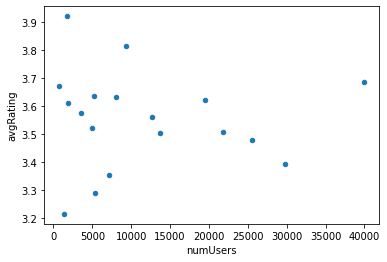

In [ ]:
# 장르별 평균 평점 산포도
genre_statistics.plot.scatter(x='numUsers', y='avgRating')

In [ ]:
# Genre 별 steamRating을 이용해 Top 10 구하기
genre = 'Action'

movie_statistics_with_genre = pd.merge(movie_statistics, movies_df, how='inner', on='movie_id')
top10_df_genre = movie_statistics_with_genre[movie_statistics_with_genre[genre] == 1]\
                    .sort_values(by='steamRating', ascending=False)[:10]
top10_df_genre

,movie_id,numUsers,avgRating,stdRating,steamRating,score,movie_title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
49,50,583,4.358491,0.881341,4.158731,1038.844786,Star Wars (1977),01-Jan-1977,NaN,http://us.imdb.com/M/title-exact?Star%20Wars%2...,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0
126,127,413,4.283293,0.934577,4.073956,745.770461,"Godfather, The (1972)",01-Jan-1972,NaN,"http://us.imdb.com/M/title-exact?Godfather,%20...",0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0
173,174,420,4.252381,0.891819,4.049117,757.974657,Raiders of the Lost Ark (1981),01-Jan-1981,NaN,http://us.imdb.com/M/title-exact?Raiders%20of%...,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
312,313,350,4.245714,0.946822,4.032126,635.329245,Titanic (1997),01-Jan-1997,NaN,http://us.imdb.com/M/title-exact?imdb-title-12...,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
171,172,367,4.204360,0.922803,4.000789,665.241548,"Empire Strikes Back, The (1980)",01-Jan-1980,NaN,http://us.imdb.com/M/title-exact?Empire%20Stri...,0,1,1,0,0,0,0,0,1,0,0,0,0,0,1,1,0,1,0
172,173,324,4.172840,0.998948,3.967019,589.412998,"Princess Bride, The (1987)",01-Jan-1987,NaN,http://us.imdb.com/M/title-exact?Princess%20Br...,0,1,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
514,515,201,4.203980,0.901767,3.960037,369.065495,"Boot, Das (1981)",04-Apr-1997,NaN,"http://us.imdb.com/M/title-exact?Boot,%20Das%2...",0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0
186,187,209,4.186603,0.919141,3.948989,383.573050,"Godfather: Part II, The (1974)",01-Jan-1974,NaN,http://us.imdb.com/M/title-exact?Godfather:%20...,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0
21,22,297,4.151515,0.962440,3.944074,541.504651,Braveheart (1995),16-Feb-1996,NaN,http://us.imdb.com/M/title-exact?Braveheart%20...,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0
497,498,152,4.184211,0.758362,3.923218,279.585197,"African Queen, The (1951)",01-Jan-1951,NaN,http://us.imdb.com/M/title-exact?African%20Que...,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0


### 사용자 데모그래픽을 활용한 추천

In [ ]:
demo_ratings_df = pd.merge(ratings_df, users_df, how='inner', on='user_id')

def age_map(x):
    if x < 20:
        return 10
    elif 20 <= x and x < 30:
        return 20
    elif 30 <= x and x < 40:
        return 30
    elif 40 <= x and x < 50:
        return 40
    else:
        return 50

demo_ratings_df['age'] = demo_ratings_df['age'].apply(lambda x: age_map(x))

# 영화 ranking을 위한 영화별 통계량 계산

demo_movie_statistics = pd.DataFrame({
    'numUsers': demo_ratings_df.groupby(['gender', 'age', 'movie_id'])['user_id'].nunique(),
    'avgRating': demo_ratings_df.groupby(['gender', 'age', 'movie_id'])['rating'].mean(), 
    'stdRating': demo_ratings_df.groupby(['gender', 'age', 'movie_id'])['rating'].std()
}).reset_index()

demo_movie_statistics.head()

,gender,age,movie_id,numUsers,avgRating,stdRating
0,F,10,1,13,3.769231,1.091928
1,F,10,2,2,3.000000,1.414214
2,F,10,3,1,5.000000,NaN
3,F,10,4,2,2.500000,0.707107
4,F,10,5,2,4.500000,0.707107


In [ ]:
# Steam Rating
demo_movie_statistics['steamRating'] = demo_movie_statistics['avgRating'] \
                                        - (demo_movie_statistics['avgRating'] - 3.0) * np.power(2, -np.log10(demo_movie_statistics['numUsers']))


In [ ]:
# 30대 남자
gender = 'M'
age = 30

filter_df = demo_movie_statistics[(demo_movie_statistics['gender'] == gender) & (demo_movie_statistics['age'] == age)]
top10_df = filter_df.sort_values(by='steamRating')[:10]
pd.merge(top10_df, movies_df[['movie_id', 'movie_title', 'release_date']], how='inner', on='movie_id')

,gender,age,movie_id,numUsers,avgRating,stdRating,steamRating,movie_title,release_date
0,M,30,1215,10,1.600000,0.699206,2.300000,Barb Wire (1996),03-May-1996
1,M,30,688,8,1.500000,1.069045,2.302110,Leave It to Beaver (1997),22-Aug-1997
2,M,30,457,5,1.200000,0.447214,2.308821,Free Willy 3: The Rescue (1997),08-Aug-1997
3,M,30,383,5,1.200000,0.447214,2.308821,"Flintstones, The (1994)",01-Jan-1994
4,M,30,948,10,1.700000,0.948683,2.350000,Booty Call (1997),28-Feb-1997
5,M,30,325,23,1.956522,1.065076,2.362556,Crash (1996),21-Mar-1997
6,M,30,368,5,1.400000,0.894427,2.385619,Bio-Dome (1996),01-Jan-1996
7,M,30,1013,5,1.400000,0.547723,2.385619,Anaconda (1997),11-Apr-1997
8,M,30,120,15,1.933333,0.883715,2.405385,Striptease (1996),28-Jun-1996
9,M,30,1234,3,1.000000,0.000000,2.436819,Chairman of the Board (1998),01-Jan-1998


In [ ]:
# 40대 여자
gender = 'F'
age = 20

filter_df = demo_movie_statistics[(demo_movie_statistics['gender'] == gender) & (demo_movie_statistics['age'] == age)]
top10_df = filter_df.sort_values(by='steamRating')[:10]
pd.merge(top10_df, movies_df[['movie_id', 'movie_title', 'release_date']], how='inner', on='movie_id')

,gender,age,movie_id,numUsers,avgRating,stdRating,steamRating,movie_title,release_date
0,F,20,569,5,1.400000,0.894427,2.385619,Wolf (1994),01-Jan-1994
1,F,20,669,4,1.250000,0.500000,2.402922,Body Parts (1991),01-Jan-1991
2,F,20,590,3,1.000000,0.000000,2.436819,Hellraiser: Bloodline (1996),08-Mar-1996
3,F,20,545,3,1.000000,0.000000,2.436819,Vampire in Brooklyn (1995),01-Jan-1995
4,F,20,1079,5,1.600000,1.341641,2.462417,Joe's Apartment (1996),26-Jul-1996
5,F,20,997,4,1.500000,1.000000,2.488219,Stuart Saves His Family (1995),01-Jan-1995
6,F,20,1229,4,1.500000,0.577350,2.488219,Poison Ivy II (1995),01-Jan-1995
7,F,20,743,4,1.500000,0.577350,2.488219,"Crow: City of Angels, The (1996)",30-Aug-1996
8,F,20,554,7,1.857143,0.899735,2.493341,Waterworld (1995),01-Jan-1995
9,F,20,240,12,2.083333,0.996205,2.517189,Beavis and Butt-head Do America (1996),20-Dec-1996


In [ ]:
for gender in ['M', 'F']:
    for age in [10, 20, 30, 40, 50, 60]:
        filter_df = demo_movie_statistics[(demo_movie_statistics['gender'] == gender) & (demo_movie_statistics['age'] == age)]
        top10_df = filter_df.sort_values(by = 'steamRating', ascending=False)[:10]
        print(gender, age)
        print(pd.merge(top10_df, movies_df[['movie_id', 'movie_title', 'release_date']], how='inner', on ='movie_id')['movie_title'].values)

M 10
['Star Wars (1977)' 'Empire Strikes Back, The (1980)'
 'Return of the Jedi (1983)' 'Shawshank Redemption, The (1994)'
 'Good Will Hunting (1997)' 'Usual Suspects, The (1995)' 'Clerks (1994)'
 'Godfather, The (1972)' 'Godfather: Part II, The (1974)'
 'Casablanca (1942)']
M 20
['Shawshank Redemption, The (1994)' 'Star Wars (1977)'
 'Godfather, The (1972)' 'Silence of the Lambs, The (1991)'
 'Usual Suspects, The (1995)' 'Empire Strikes Back, The (1980)'
 'Princess Bride, The (1987)' 'Raiders of the Lost Ark (1981)'
 'Titanic (1997)' 'Casablanca (1942)']
M 30
['Casablanca (1942)' 'Star Wars (1977)'
 "One Flew Over the Cuckoo's Nest (1975)" 'Rear Window (1954)'
 'North by Northwest (1959)' 'Godfather, The (1972)'
 'Raiders of the Lost Ark (1981)' "Schindler's List (1993)"
 'Usual Suspects, The (1995)' 'Raging Bull (1980)']
M 40
['Casablanca (1942)' "Schindler's List (1993)" 'Wizard of Oz, The (1939)'
 'Usual Suspects, The (1995)' 'Shawshank Redemption, The (1994)'
 'Ran (1985)' 'Vertig

# Association Rule 구현
- 10개의 `transaction`으로 이루어진 데이터를 활용하여 `association rule`을 간단하게 구현
- `support`, `confidence`, `lift` 값을 직접 구해보기

## Association Rule Mining 방법

주어진 `transaction` 가운데, 아래 조건을 만족하는 간으한 모든 연관 규칙을 찾는다.
1. `support` $ \geqslant $ 최소 `support`
2. `confidence` $ \geqslant $ 최소 `confidence`

위 조건을 만족하는 모든 연관 규칙은 어떻게 찾는가?

### Brute-force Apporach

1. 가능한 모든 연관 규칙을 리스팅
2. 모든 연관 규칙에 대해서 개별 `support`와 `confidence`를 계산
3. 최소 `support`, `confidence`를 만족하는 `rule`만 남기고 모두 가지친다`pruning`.
**$ \to $ 모든 연관 규칙을 찾아서 계산하기 위해선 매우 많은 계산량을 요구하기 때문!**


`Transaction`에 있는 각 `itemset`은 `frequent itemset`의 후보이며, 개별 `itemset`에 대하여 일일이 데이터베이스를 풀스캔하여 `support`를 계산한다.

Complexity ~ 0(NMw), M = $ 2^{d} $(d: # of unique items) $ \to $ M이 가장 큰 문제!

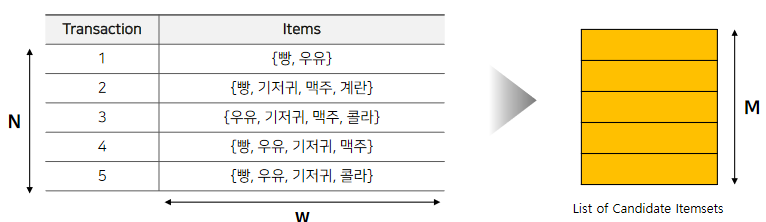

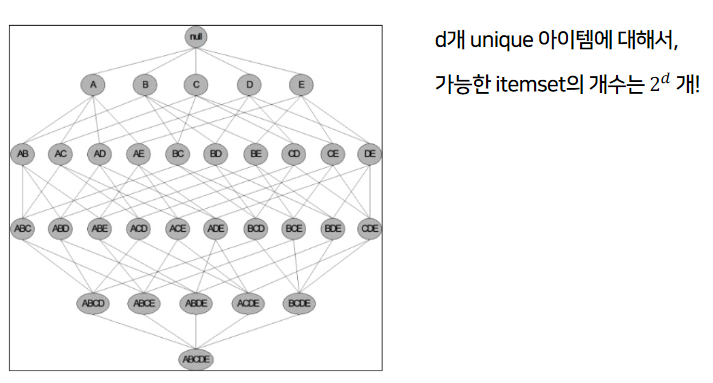

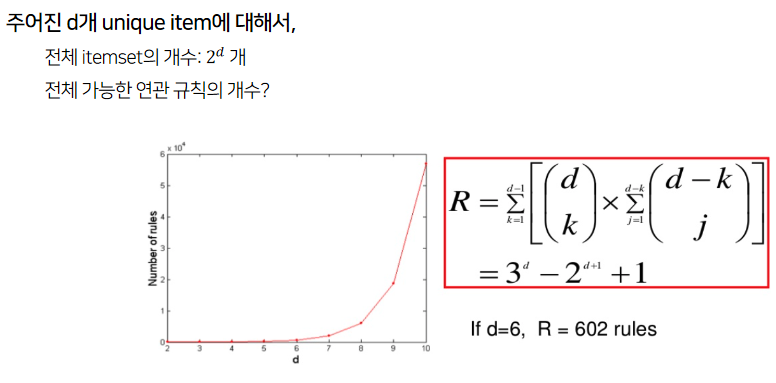

## 효율적인 Frequent Itemset Generation이 필요!

`Assciation Rule Mining`을 하기 위해선 두가지 Step을 거쳐야 합니다.


### 1. Frequent Itemset Generation



최소 `support` 이상의 모든 `itemset`을 생성한다.

### 2. Rule Generation
최소 `confidence` 이상의 `association rule`을 생성한다.<br>
이때 `rule`을 이루는 `antecedent`와 `consequent`는 서로소`disjoint`를 만족해야 합니다.


$ \to $ 여기서 1번 Task가 가장 performance를 많이 잡아 먹습니다.

## Frequent Item Generation Strategies

### 1. 가능한 후보 itemset의 개수를 줄인다(M).

완전 탐색: M = $ 2^{d} $ $\to$ **Apriori 알고리즘** : 가지치기`Pruning`를 활용하여 탐색해야 하는 M을 줄인다

### 2. 탐색하는 transaction의 숫자를 줄인다(N).

`itemset`의 크기가 커지면서 전체 N개 `transaction`보다 적은 개수를 탐색 $\to$ **DHP`Direct Hashing & Pruning` 알고리즘**

### 3. N * M 탐색 횟수를 줄인다(NM).

효율적인 자료구조를 사용하여 후보 `itemset`과 `transaction`을 저장<br>
모든 `itemset`과 `transaction`의 조합에 대해서 탐색할 필요가 없다. $\to$ **FP-Growth 알고리즘**


## 필요 Library 설치 및 Import

In [ ]:
pip install mlxtend --upgrade --no-deps

     |████████████████████████████████| 1.4MB 7.9MB/s 
  Found existing installation: mlxtend 0.14.0
    Uninstalling mlxtend-0.14.0:
      Successfully uninstalled mlxtend-0.14.0


In [ ]:
import csv
import pandas as pd
import random
from datetime import datetime
from collections import defaultdict
import seaborn as sns
import numpy as np

from mlxtend.frequent_patterns import apriori, fpgrowth
from mlxtend.frequent_patterns import association_rules
from mlxtend.preprocessing import TransactionEncoder

from matplotlib import pyplot as plt
%matplotlib inline

In [ ]:
!head -n 5 '/content/drive/MyDrive/Colab_Notebook/learning_spoons_recommendation_system/data/transaction.csv'

Bread,Milk
Bread,Diapers,Beer,Eggs
Milk,Diapers,Beer,Cola
Bread,Milk,Diapers,Beer
Bread,Milk,Diapers,Cola


In [ ]:
file_path = '/content/drive/MyDrive/Colab_Notebook/learning_spoons_recommendation_system/data/transaction.csv'
trans_list_set = []

with open(file_path, 'r') as file:
    reader = csv.reader(file, delimiter=',')
    for line in reader:
        trans_list_set.append(set(line))

trans_length = len(trans_list_set)  # 10
trans_list_set

[{'Bread', 'Milk'},
 {'Beer', 'Bread', 'Diapers', 'Eggs'},
 {'Beer', 'Cola', 'Diapers', 'Milk'},
 {'Beer', 'Bread', 'Diapers', 'Milk'},
 {'Bread', 'Cola', 'Diapers', 'Milk'},
 {'Bread', 'Milk'},
 {'Beer', 'Bread', 'Cola', 'Milk'},
 {'Beer', 'Bread', 'Cola', 'Milk'},
 {'Beer', 'Bread', 'Diapers', 'Milk'},
 {'Beer', 'Bread', 'Diapers'}]

- `frozenset`을 사용하는 이유
    - 우리가 필요한 `itemset`은 python에서 제공하는 `set`과 동일
    - `frozenset`은 불변 객체이므로 새로운 아이템의 추가나 삭제가 불가 $\to$ 사용하는 이유!, `pandas`에도 `value` 값으로 사용할 수 있다

In [ ]:
# 1-itemset 생성

item_set = set()
for line in trans_list_set:
    for item in line:
        item_set.add(frozenset([item]))
item_set

{frozenset({'Diapers'}),
 frozenset({'Cola'}),
 frozenset({'Bread'}),
 frozenset({'Eggs'}),
 frozenset({'Beer'}),
 frozenset({'Milk'})}

## support 계산, frequent itemset 구하기

In [ ]:
# frequent itemset의 support를 저장하는 dictionary
# frequent itemset : 최소한의 support 이상의 k-itemset을 의미

min_support = 0.2
support_dict = defaultdict(float)

In [ ]:
# 1-itemset의 frequent itemset 계산
one_freq_set = set()
one_freq_dict = defaultdict(int)

# 1-itemset의 support count 계산
for item in item_set:
    one_freq_dict[item] += sum([1 for trans in trans_list_set if item.issubset(trans)])

# min support 이상의 itemset만 보존

n = len(trans_list_set)
for item, cnt in one_freq_dict.items():
    support = float(cnt) / n
    if support >= min_support:
        one_freq_set.add(item)
        support_dict[item] = support

print('{0:=^60}'.format('1-itemset'))
support_dict


=========================1-itemset==========================


defaultdict(float,
            {frozenset({'Diapers'}): 0.6,
             frozenset({'Cola'}): 0.4,
             frozenset({'Bread'}): 0.9,
             frozenset({'Beer'}): 0.7,
             frozenset({'Milk'}): 0.8,
             frozenset({'Beer', 'Bread'}): 0.6,
             frozenset({'Diapers', 'Milk'}): 0.4,
             frozenset({'Beer', 'Cola'}): 0.3,
             frozenset({'Beer', 'Diapers'}): 0.5,
             frozenset({'Cola', 'Diapers'}): 0.2,
             frozenset({'Bread', 'Cola'}): 0.3,
             frozenset({'Bread', 'Diapers'}): 0.5,
             frozenset({'Beer', 'Milk'}): 0.5,
             frozenset({'Cola', 'Milk'}): 0.4,
             frozenset({'Bread', 'Milk'}): 0.7})

In [ ]:

# 2-frequency itemset

k = 2
two_item_set = set([term1.union(term2) for term1 in one_freq_set
                        for term2 in one_freq_set if len(term1.union(term2)) == k])

two_freq_set = set()
two_freq_dict = defaultdict(int)

# 2-itemset의 support count 계산
for item in two_item_set:
    two_freq_dict[item] += sum(1 for trans in trans_list_set if item.issubset(trans))

n = len(trans_list_set)
for item, cnt in two_freq_dict.items():
    support = float(cnt) / n
    if support >= min_support:
        one_freq_set.add(item)
        support_dict[item] = support

print('{0:=^60}'.format('2-frequency itemset'))
support_dict

====================2-frequency itemset=====================


defaultdict(float,
            {frozenset({'Diapers'}): 0.6,
             frozenset({'Cola'}): 0.4,
             frozenset({'Bread'}): 0.9,
             frozenset({'Beer'}): 0.7,
             frozenset({'Milk'}): 0.8,
             frozenset({'Beer', 'Bread'}): 0.6,
             frozenset({'Diapers', 'Milk'}): 0.4,
             frozenset({'Beer', 'Cola'}): 0.3,
             frozenset({'Beer', 'Diapers'}): 0.5,
             frozenset({'Cola', 'Diapers'}): 0.2,
             frozenset({'Bread', 'Cola'}): 0.3,
             frozenset({'Bread', 'Diapers'}): 0.5,
             frozenset({'Beer', 'Milk'}): 0.5,
             frozenset({'Cola', 'Milk'}): 0.4,
             frozenset({'Bread', 'Milk'}): 0.7})

In [ ]:
# 3-frequency itemset을 생성하는 과정

k = 3

# 2-itemset을 사용해서 후보 3-itemset들을 생성합니다
three_item_set = set([term1.union(term2) for term1 in two_freq_set for term2 in two_freq_set if len(term1.union(term2)) == k])

three_freq_set  = set()
three_freq_dict = defaultdict(int)

# 2-itemset의 support count 계산
for item in three_item_set:
    three_freq_dict[item] += sum([1 for trans in trans_list_set if item.issubset(trans)])

# 2-itemset 가운데 min support 이상의 itemset만 보존시킨다.
n = len(trans_list_set)
for item, cnt in three_freq_dict.items():
    support = float(cnt) / n
    if support >= min_support:
        three_freq_set.add(item)
        support_dict[item] = support

support_dict

defaultdict(float,
            {frozenset({'Diapers'}): 0.6,
             frozenset({'Cola'}): 0.4,
             frozenset({'Bread'}): 0.9,
             frozenset({'Beer'}): 0.7,
             frozenset({'Milk'}): 0.8,
             frozenset({'Beer', 'Bread'}): 0.6,
             frozenset({'Diapers', 'Milk'}): 0.4,
             frozenset({'Beer', 'Cola'}): 0.3,
             frozenset({'Beer', 'Diapers'}): 0.5,
             frozenset({'Cola', 'Diapers'}): 0.2,
             frozenset({'Bread', 'Cola'}): 0.3,
             frozenset({'Bread', 'Diapers'}): 0.5,
             frozenset({'Beer', 'Milk'}): 0.5,
             frozenset({'Cola', 'Milk'}): 0.4,
             frozenset({'Bread', 'Milk'}): 0.7})

## confidence, lift 구하기

X $\to$ Y, X : `antecedent` Y : `consequent`

In [ ]:
x = 'Diapers'
y = 'Beer'

x_support = support_dict.get(frozenset([x]), 0.0)
y_support = support_dict.get(frozenset([y]), 0.0)
both_support = support_dict.get(frozenset([x, y]), 0.0)

confidence = both_support / x_support
print('Confidence : ', confidence)

lift = both_support / (x_support * y_support)
print('Lift : ', lift)

Confidence :  0.8333333333333334
Lift :  1.1904761904761905


## association rule 구하기

X에 대해 가능한 모든 `association rule`을 구하기

In [ ]:
x = 'Diapers'
x = frozenset([x])
x_support = support_dict.get(x, 0.0)

for y, y_support in support_dict.items():
    if y != x:
        y_support = support_dict.get(y, 0.0)
        both_support = support_dict.get(x.union(y), 0.0)

        confidence = both_support / x_support
        lift = both_support / (x_support * y_support)

        print('%s -> %s support : %0.3f, confidence : %0.3f, lift : %0.3f' \
              % (list(x), list(y), both_support, confidence, lift))

['Diapers'] -> ['Cola'] support : 0.200, confidence : 0.333, lift : 0.833
['Diapers'] -> ['Bread'] support : 0.500, confidence : 0.833, lift : 0.926
['Diapers'] -> ['Beer'] support : 0.500, confidence : 0.833, lift : 1.190
['Diapers'] -> ['Milk'] support : 0.400, confidence : 0.667, lift : 0.833
['Diapers'] -> ['Bread', 'Beer'] support : 0.000, confidence : 0.000, lift : 0.000
['Diapers'] -> ['Diapers', 'Milk'] support : 0.400, confidence : 0.667, lift : 1.667
['Diapers'] -> ['Beer', 'Cola'] support : 0.000, confidence : 0.000, lift : 0.000
['Diapers'] -> ['Diapers', 'Beer'] support : 0.500, confidence : 0.833, lift : 1.667
['Diapers'] -> ['Diapers', 'Cola'] support : 0.200, confidence : 0.333, lift : 1.667
['Diapers'] -> ['Bread', 'Cola'] support : 0.000, confidence : 0.000, lift : 0.000
['Diapers'] -> ['Diapers', 'Bread'] support : 0.500, confidence : 0.833, lift : 1.667
['Diapers'] -> ['Milk', 'Beer'] support : 0.000, confidence : 0.000, lift : 0.000
['Diapers'] -> ['Milk', 'Cola'] 

모든 서로소`disjoint`에 대하여 가능한 `association rule`을 구하는 로직입니다.

In [ ]:
result_df = pd.DataFrame(columns= ['antecedent', 'consequent', 'support', 'confidence', 'lift'])

for x, x_support in support_dict.items():
    for y, y_support in support_dict.items():
        if x.isdisjoint(y):
            both_support = support_dict.get(x.union(y), 0.0)

            confidence = both_support / x_support
            lift = both_support / (x_support * y_support)
            result_df.loc[len(result_df)] = [x, y, both_support, confidence, lift]

result_df

,antecedent,consequent,support,confidence,lift
0,(Diapers),(Cola),0.2,0.333333,0.833333
1,(Diapers),(Bread),0.5,0.833333,0.925926
2,(Diapers),(Beer),0.5,0.833333,1.190476
3,(Diapers),(Milk),0.4,0.666667,0.833333
4,(Diapers),"(Bread, Beer)",0.0,0.000000,0.000000
...,...,...,...,...,...
105,"(Milk, Bread)",(Cola),0.0,0.000000,0.000000
106,"(Milk, Bread)",(Beer),0.0,0.000000,0.000000
107,"(Milk, Bread)","(Beer, Cola)",0.0,0.000000,0.000000
108,"(Milk, Bread)","(Diapers, Beer)",0.0,0.000000,0.000000


## association rule을 사용한 추천

In [ ]:
support_dict

defaultdict(float,
            {frozenset({'Diapers'}): 0.6,
             frozenset({'Cola'}): 0.4,
             frozenset({'Bread'}): 0.9,
             frozenset({'Beer'}): 0.7,
             frozenset({'Milk'}): 0.8,
             frozenset({'Beer', 'Bread'}): 0.6,
             frozenset({'Diapers', 'Milk'}): 0.4,
             frozenset({'Beer', 'Cola'}): 0.3,
             frozenset({'Beer', 'Diapers'}): 0.5,
             frozenset({'Cola', 'Diapers'}): 0.2,
             frozenset({'Bread', 'Cola'}): 0.3,
             frozenset({'Bread', 'Diapers'}): 0.5,
             frozenset({'Beer', 'Milk'}): 0.5,
             frozenset({'Cola', 'Milk'}): 0.4,
             frozenset({'Bread', 'Milk'}): 0.7})

- Diapers는 `frequent itemset`에 속하므로 `association rule`을 통한 추천이 가능합니다.
- Diapers를 구매했다고 가정할 때 추천 `itemset`을 구해봅니다.

In [ ]:
x = 'Diapers'
x_itemset = frozenset([x])
result_df[result_df['antecedent'] == x_itemset].sort_values(by='lift', ascending=False)

,antecedent,consequent,support,confidence,lift
2,(Diapers),(Beer),0.5,0.833333,1.190476
1,(Diapers),(Bread),0.5,0.833333,0.925926
0,(Diapers),(Cola),0.2,0.333333,0.833333
3,(Diapers),(Milk),0.4,0.666667,0.833333
4,(Diapers),"(Bread, Beer)",0.0,0.000000,0.000000
5,(Diapers),"(Beer, Cola)",0.0,0.000000,0.000000
6,(Diapers),"(Bread, Cola)",0.0,0.000000,0.000000
7,(Diapers),"(Milk, Beer)",0.0,0.000000,0.000000
8,(Diapers),"(Milk, Cola)",0.0,0.000000,0.000000
9,(Diapers),"(Milk, Bread)",0.0,0.000000,0.000000


최소 confidence 조건을 추가하려면 아래와 같이 합니다.

In [ ]:
x = 'Diapers'
x_itemset = frozenset([x])
min_confidence = 0.3

result_df[(result_df['antecedent'] == x_itemset) \
            & result_df['confidence'] > min_confidence].sort_values(by='lift', ascending=False)

,antecedent,consequent,support,confidence,lift
2,(Diapers),(Beer),0.5,0.833333,1.190476
1,(Diapers),(Bread),0.5,0.833333,0.925926
0,(Diapers),(Cola),0.2,0.333333,0.833333
3,(Diapers),(Milk),0.4,0.666667,0.833333


## mlxtend 라이브러리 사용

- `frequent itemset`을 생성하는 `Aporiori` 알고리즘과 `Association Rule`을 제공하는 라이브러리
- `Apriori` 알고리즘 외에도 더 빠른 `FPGrowth` 등의 알고리즘도 제공

In [ ]:
file_path = '/content/drive/MyDrive/Colab_Notebook/learning_spoons_recommendation_system/data/transaction.csv'
transaction_df = pd.DataFrame(columns=['transaction', 'item'])

index = 0
with open(file_path, 'r') as file:
    reader = csv.reader(file, delimiter=',')
    for line in reader:
        for item in line:
            transaction_df.loc[len(transaction_df)] = [index, item]
        index += 1

transaction_df

,transaction,item
0,0,Bread
1,0,Milk
2,1,Bread
3,1,Diapers
4,1,Beer
5,1,Eggs
6,2,Milk
7,2,Diapers
8,2,Beer
9,2,Cola


그중 Top N 아이템을 구합니다

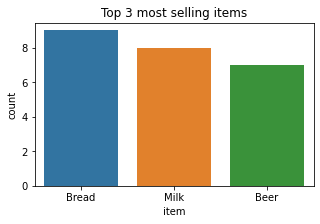

In [ ]:
plt.figure(figsize=(5,3))
order = transaction_df['item'].value_counts()[:3].index
sns.countplot(x='item', data=transaction_df, order=order)
plt.title('Top 3 most selling items')
plt.show()

다음은 `mlxtend` 라이브러리 학습을 위한 데이터 포맷을 변경합니다.

In [ ]:
from mlxtend.preprocessing import TransactionEncoder

dataset = []

# 2개 이상의 item으로 이뤄진 itemset만 사용
for transaction, df in transaction_df.groupby('transaction'):
    item_list = list(df['item'].unique())
    if len(item_list) > 1:
        dataset.append(item_list)
dataset

[['Bread', 'Milk'],
 ['Bread', 'Diapers', 'Beer', 'Eggs'],
 ['Milk', 'Diapers', 'Beer', 'Cola'],
 ['Bread', 'Milk', 'Diapers', 'Beer'],
 ['Bread', 'Milk', 'Diapers', 'Cola'],
 ['Bread', 'Milk'],
 ['Bread', 'Cola', 'Beer', 'Milk'],
 ['Milk', 'Bread', 'Beer', 'Cola'],
 ['Bread', 'Milk', 'Diapers', 'Beer'],
 ['Bread', 'Beer', 'Diapers']]

In [ ]:
te = TransactionEncoder()
te_ary = te.fit(dataset).transform(dataset)
df = pd.DataFrame(te_ary, columns=te.columns_)
df

,Beer,Bread,Cola,Diapers,Eggs,Milk
0,False,True,False,False,False,True
1,True,True,False,True,True,False
2,True,False,True,True,False,True
3,True,True,False,True,False,True
4,False,True,True,True,False,True
5,False,True,False,False,False,True
6,True,True,True,False,False,True
7,True,True,True,False,False,True
8,True,True,False,True,False,True
9,True,True,False,True,False,False


In [ ]:
# frequent itemset 생성

from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

frequent_itemsets = apriori(df, min_support=0.2, use_colnames=True)
frequent_itemsets

,support,itemsets
0,0.7,(Beer)
1,0.9,(Bread)
2,0.4,(Cola)
3,0.6,(Diapers)
4,0.8,(Milk)
5,0.6,"(Bread, Beer)"
6,0.3,"(Beer, Cola)"
7,0.5,"(Diapers, Beer)"
8,0.5,"(Milk, Beer)"
9,0.3,"(Bread, Cola)"


최소 `Confidence` 이상의 `association rule` 생성 및 추천

In [ ]:
result = association_rules(frequent_itemsets, metric='confidence', min_threshold=0.3)
result[(result['antecedents'] == frozenset(['Beer']))].sort_values(by='lift', ascending=False)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
5,(Beer),(Diapers),0.7,0.6,0.5,0.714286,1.190476,0.08,1.400000
29,(Beer),"(Diapers, Bread)",0.7,0.5,0.4,0.571429,1.142857,0.05,1.166667
2,(Beer),(Cola),0.7,0.4,0.3,0.428571,1.071429,0.02,1.050000
40,(Beer),"(Milk, Cola)",0.7,0.4,0.3,0.428571,1.071429,0.02,1.050000
47,(Beer),"(Diapers, Milk)",0.7,0.4,0.3,0.428571,1.071429,0.02,1.050000
1,(Beer),(Bread),0.7,0.9,0.6,0.857143,0.952381,-0.03,0.700000
7,(Beer),(Milk),0.7,0.8,0.5,0.714286,0.892857,-0.06,0.700000
35,(Beer),"(Milk, Bread)",0.7,0.7,0.4,0.571429,0.816327,-0.09,0.700000


- 최소 `lift` 이상의 `association rule` 생성 및 추천
- 일반적으로 위와 같이 최소 `confidence`로 `rule`을 cutoff하고 `lift`로 정렬해서 사용합니다.


In [ ]:
result = association_rules(frequent_itemsets, metric='lift', min_threshold=1.1)
result[(result['antecedents'] == frozenset(['Beer']))].sort_values(by='lift', ascending=False)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
1,(Beer),(Diapers),0.7,0.6,0.5,0.714286,1.190476,0.08,1.400000
7,(Beer),"(Diapers, Bread)",0.7,0.5,0.4,0.571429,1.142857,0.05,1.166667


## Online Retail 데이터를 활용한 Association Rule 생성
- 실제 데이터를 사용해서 간단한 연관 규칙 기반 상품 추천 시스템 제작

### Data Preprocessing

In [ ]:
!wc -l '/content/drive/MyDrive/Colab_Notebook/learning_spoons_recommendation_system/data/online_retail/online_retail.csv'

541909 /content/drive/MyDrive/Colab_Notebook/learning_spoons_recommendation_system/data/online_retail/online_retail.csv


In [ ]:
!head '/content/drive/MyDrive/Colab_Notebook/learning_spoons_recommendation_system/data/online_retail/online_retail.csv'

﻿InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26,2.55,17850,United Kingdom
536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26,3.39,17850,United Kingdom
536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26,2.75,17850,United Kingdom
536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26,3.39,17850,United Kingdom
536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26,3.39,17850,United Kingdom
536365,22752,SET 7 BABUSHKA NESTING BOXES,2,2010-12-01 08:26,7.65,17850,United Kingdom
536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,2010-12-01 08:26,4.25,17850,United Kingdom
536366,22633,HAND WARMER UNION JACK,6,2010-12-01 08:28,1.85,17850,United Kingdom
536366,22632,HAND WARMER RED POLKA DOT,6,2010-12-01 08:28,1.85,17850,United Kingdom


In [ ]:
file_path = '/content/drive/MyDrive/Colab_Notebook/learning_spoons_recommendation_system/data/online_retail/online_retail.csv'
parse_date = lambda x : datetime.strptime(x, '%Y-%m-%d %H:%M')
retail_df = pd.read_csv(file_path, encoding='utf-8', parse_dates = ['InvoiceDate'], date_parser = parse_date)

여기서 quantity가 음수인 데이터는 제거

In [ ]:
retail_df = retail_df[retail_df.Quantity > 0]

In [ ]:
retail_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 531285 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    531285 non-null  object        
 1   StockCode    531285 non-null  object        
 2   Description  530693 non-null  object        
 3   Quantity     531285 non-null  int64         
 4   InvoiceDate  531285 non-null  datetime64[ns]
 5   UnitPrice    531285 non-null  float64       
 6   CustomerID   397924 non-null  float64       
 7   Country      531285 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 36.5+ MB


In [ ]:
# 아이템 총 개수
print(retail_df['StockCode'].nunique())

3941


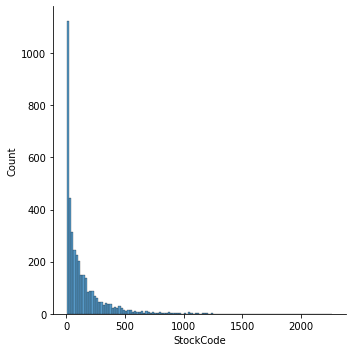

In [ ]:
# 아이템 별 transaction 등장 수 분포
sns.displot(retail_df['StockCode'].value_counts())

현재 주어진 로그의 경우, 단일 아이템 하나당 하나의 로그가 남는다. 그래서 `transaction` 단위로 묶어보자

In [ ]:
transaction_df = pd.DataFrame({
    'items' : retail_df.groupby(['InvoiceNo'])['StockCode'].apply(set),
    'item_length' : retail_df.groupby(['InvoiceNo'])['StockCode'].nunique()
}).reset_index()
transaction_df

,InvoiceNo,items,item_length
0,536365,"{84406B, 22752, 84029G, 21730, 85123A, 84029E,...",7
1,536366,"{22632, 22633}",2
2,536367,"{84879, 22749, 22748, 48187, 22310, 84969, 217...",12
3,536368,"{22913, 22914, 22960, 22912}",4
4,536369,{21756},1
...,...,...,...
20723,581586,"{22061, 21217, 20685, 23275}",4
20724,581587,"{22556, 23256, 23254, 22899, 22629, 22631, 223...",15
20725,A563185,{B},1
20726,A563186,{B},1


2개 이상의 아이템으로 이뤄진 itemset만 추려봅니다.

In [ ]:
transaction_df[transaction_df.item_length > 1]

,InvoiceNo,items,item_length
0,536365,"{84406B, 22752, 84029G, 21730, 85123A, 84029E,...",7
1,536366,"{22632, 22633}",2
2,536367,"{84879, 22749, 22748, 48187, 22310, 84969, 217...",12
3,536368,"{22913, 22914, 22960, 22912}",4
5,536370,"{21035, 22544, 10002, 22631, 22326, 22629, 226...",20
...,...,...,...
20720,581583,"{20725, 85038}",2
20721,581584,"{20832, 85038}",2
20722,581585,"{21684, 23145, 22398, 84879, 23084, 16016, 224...",21
20723,581586,"{22061, 21217, 20685, 23275}",4


### frequent itemset 생성

`frequent itemset`, `rule generation`을 위한 데이터를 변환합니다.

In [ ]:
from mlxtend.preprocessing import TransactionEncoder

dataset = []

# 2개 이상의 item으로 이뤄진 itemset만 사용
for index, row in transaction_df[transaction_df.item_length > 1].reset_index().iterrows():
    dataset.append(list(row['items']))

te = TransactionEncoder()
te_ary = te.fit(dataset).transform(dataset)
df = pd.DataFrame(te_ary, columns=te.columns_)
df

,10002,10080,10120,10123C,10124A,10124G,10125,10133,10135,11001,15030,15034,15036,15039,15044A,15044B,15044C,15044D,15056BL,15056N,15056P,15056bl,15056n,15056p,15058A,15058B,15058C,15060B,15060b,16008,16010,16011,16012,16014,16015,16016,16020C,16033,16043,16045,...,90214C,90214D,90214E,90214F,90214G,90214H,90214I,90214J,90214K,90214L,90214M,90214N,90214O,90214P,90214R,90214S,90214T,90214U,90214V,90214W,90214Y,90214Z,C2,DCGS0003,DCGS0004,DCGS0069,DCGS0070,DCGS0076,DCGSSBOY,DCGSSGIRL,DOT,M,PADS,POST,gift_0001_10,gift_0001_20,gift_0001_30,gift_0001_40,gift_0001_50,m
0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18333,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
18334,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,Fals

`Apriori` library으로 최소 `support`를 충족하는 `itemset`을 가지치기`pruning`해 구해봅니다

In [ ]:
%%time

min_support = 0.01

frequent_itemsets = apriori(df, min_support=min_support, use_colnames=True)
# frequent_itemsets = fpgrowth(df, min_support=min_support, use_colnames=True)

KeyboardInterrupt: ignored

In [ ]:
%%time

min_support = 0.01

# frequent_itemsets = apriori(df, min_support=min_support, use_colnames=True)
frequent_itemsets = fpgrowth.fpgrowth(df, min_support=min_support, use_colnames=True)

CPU times: user 9.48 s, sys: 103 ms, total: 9.58 s
Wall time: 9.61 s


### Association rule 생성 및 상품 추천

높은 `support`를 가진 아이템 가운데 하나를 선택해서 추천해보자

In [ ]:
frequent_itemsets.sort_values(by='support', ascending=False)

,support,itemsets
0,0.119042,(85123A)
98,0.113317,(85099B)
328,0.107264,(22423)
653,0.091122,(47566)
42,0.085287,(20725)
...,...,...
1215,0.010034,"(22379, 22666)"
2259,0.010034,"(23182, 85099B)"
2079,0.010034,"(85099B, 22666, DOT)"
1153,0.010034,"(21559, 85099B)"


itemset[85099B]이 주어졌을 때 가장 연관도가 높은 아이템 10개를 추천 받을 경우,

In [ ]:
min_confidence = 0.2
k = 10

given_itemset = ['85099B']

result = association_rules(frequent_itemsets, metric='confidence', min_threshold=min_confidence)
result[(result['antecedents'] == frozenset(given_itemset))].sort_values(by='lift', ascending=False)[:k]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
2870,(85099B),(DOT),0.113317,0.038608,0.026448,0.233397,6.045259,0.022073,1.254094
157,(85099B),(22386),0.113317,0.066310,0.044989,0.397016,5.987242,0.037474,1.548449
2320,(85099B),(21928),0.113317,0.043898,0.029502,0.260346,5.930725,0.024527,1.292635
1611,(85099B),(85099F),0.113317,0.044443,0.029283,0.258422,5.814644,0.024247,1.288544
211,(85099B),(85099C),0.113317,0.050551,0.031901,0.281521,5.569068,0.026173,1.321471
3335,(85099B),(22385),0.113317,0.037463,0.023449,0.206930,5.523548,0.019203,1.213684
2038,(85099B),(20712),0.113317,0.047006,0.029174,0.257459,5.477129,0.023848,1.283423
179,(85099B),(21931),0.113317,0.064565,0.039481,0.348412,5.396265,0.032165,1.435623
306,(85099B),(21929),0.113317,0.047170,0.028247,0.249278,5.284697,0.022902,1.269219
665,(85099B),(22411),0.113317,0.064020,0.037081,0.327238,5.111487,0.029827,1.391249


### AssociationRuleMining Class

In [ ]:
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, fpgrowth
from mlxtend.frequent_patterns import association_rules

class AssociationRulMining(object):
    def __init__(self, min_supp, min_conf):
        """ Parameters setting
        """
        self.min_supp = min_supp
        self.min_conf = min_conf

    def fit(self, dataset, algorithm):
        """ Run the apriori/fpgrowth algorithm, return the frequent k-term sets and association rules.
        """
        te = TransactionEncoder()
        te_ary = te.fit(dataset).transform(dataset)
        df = pd.DataFrame(te_ary, columns=te.columns_)

        if algorithm == 'apriori':
            self.frequent_itemsets = apriori(df, min_support=self.min_supp, use_colnames=True)
        elif algorithm == 'fpgrowth':
            self.frequent_itemsets = fpgrowth.fpgrowth(df, min_support=self.min_supp, use_colnames=True)
        else:
            raise Exception('A wrong algorithm name')
        
        self.result = association_rules(frequent_itemsets, metric='confidence', min_threshold=self.min_conf)
    
    def get_available_recommend_items(self):
        """ Get 1-freq item lists greator than minimum support
        """
        tmp_df = self.result
        return [list(x)[0] for x in tmp_df[tmp_df['antecedents'].str.len() == 1]['antecedents'].unique().tolist()]
    
    def recommend_item(self, item_id, min_conf=None):
        """ Get 1-freq recommend item list sorted by lift, greater than minimum confidence
        """
        if min_conf is None:
            tmp_df = self.result
        else:
            tmp_df = association_rules(frequent_itemsets, metric='confidence', min_threshold=min_conf)
        
        tmp_df = tmp_df[(tmp_df['antecedents'] == frozenset([item_id])) & \
                        (tmp_df['consequents'].str.len() == 1)].sort_values(by='lift', ascending=False)
        
        return tmp_df[['consequents', 'confidence', 'lift']]
    
    def get_support(self, items):
        """ Get support  from item list
        """
        tmp_df = self.frequent_itemsets
        return tmp_df[tmp_df['itemsets'] == frozenset(items)]['support'].values[0]


In [ ]:
objARM = AssociationRulMining(min_supp=0.01, min_conf=0.01)
objARM.fit(dataset, 'fpgrowth')

In [ ]:
objARM.result

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(22865),(22633),0.035609,0.026066,0.012869,0.361409,13.865096,0.011941,1.525129
1,(22633),(22865),0.026066,0.035609,0.012869,0.493724,13.865096,0.011941,1.904871
2,(22866),(22633),0.029829,0.026066,0.011724,0.393053,15.079093,0.010947,1.604644
3,(22633),(22866),0.026066,0.029829,0.011724,0.449791,15.079093,0.010947,1.763277
4,(22867),(22633),0.030210,0.026066,0.010088,0.333935,12.811089,0.009301,1.462221
...,...,...,...,...,...,...,...,...,...
5635,(22633),(23439),0.026066,0.021649,0.010361,0.397490,18.360613,0.009797,1.623791
5636,(22865),(23439),0.035609,0.021649,0.011888,0.333844,15.420724,0.011117,1.468651
5637,(23439),(22865),0.021649,0.035609,0.011888,0.549118,15.420724,0.011117,2.138900
5638,(22866),(23439),0.029829,0.021649,0.010852,0.363803,16.804563,0.010206,1.537810


### Class method를 활용하여 연관분석 추천 제공

최소 `support`를 만족하는 상품, 즉 frequent itemset에 존재하는 상품이어야 연관 분석이 가능합니다.

In [ ]:
recommend_list = objARM.get_available_recommend_items()
recommend_list[:20]

['22865',
 '22633',
 '22866',
 '22867',
 '22632',
 '84879',
 '85123A',
 '22423',
 '47566',
 '21754',
 '21755',
 '22745',
 '22748',
 '22960',
 '22961',
 '85099B',
 '22197',
 '21212',
 '22457',
 '20725']

`support`가 상대적으로 높은 item의 경우 `association rule`이 많습니다.

In [ ]:
item_id = '85099B'
print('support :', objARM.get_support([item_id]))
objARM.recommend_item(item_id)

support : 0.11331661031737376


,consequents,confidence,lift
3836,(DOT),0.233397,6.045259
245,(22386),0.397016,5.987242
3136,(21928),0.260346,5.930725
2219,(85099F),0.258422,5.814644
3333,(20711),0.165544,5.804478
...,...,...,...
5180,(23298),0.107315,1.721730
5519,(23084),0.089509,1.699191
1225,(85123A),0.192974,1.621052
951,(22086),0.100577,1.599644


`Association rule`이 많은 경우 최소 `confidence` 값을 높게 잡기도 합니다.

In [ ]:
objARM.recommend_item(item_id, min_conf=0.3)

,consequents,confidence,lift
75,(22386),0.397016,5.987242
86,(21931),0.348412,5.396265
429,(22411),0.327238,5.111487


`support`가 상대적으로 낮은 `item`의 경우 `association rule`이 적다

In [ ]:
item_id = '20713'
print('support :', objARM.get_support([item_id]))
objARM.recommend_item(item_id)

support : 0.03544552295779256


,consequents,confidence,lift
2304,(DOT),0.383077,9.922125
2288,(20712),0.433846,9.229548
2306,(22385),0.303077,8.089992
2296,(21928),0.350769,7.990567
2300,(21930),0.304615,7.957318
2294,(85099C),0.395385,7.821535
2284,(21931),0.490769,7.601120
2298,(22379),0.306154,7.515729
2286,(85099F),0.303077,6.819417
2290,(22386),0.430769,6.496255


# 추천 시스템을 만들고 평가
1. 데이터를 `train` / `test`로 나눔
2. `train` 데이터를 이용해 추천 모델/시스템을 만들고 `test` 데이터로 평가
3. 평가 `지표`에 따라 **1)** 추천 결과의 형태가 달라지거나, **2)** `train`/`test` 데이터를 나누는 방법이 달라짐

## 무비렌즈 데이터 Load

In [ ]:
import os
import pandas as pd
import seaborn as sns
import numpy as np
import random
from matplotlib import pyplot as plt
from datetime import datetime
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [ ]:
path = '/content/drive/MyDrive/Colab_Notebook/learning_spoons_recommendation_system/data/ml-100k/'

In [ ]:
ratings_df = pd.read_csv(path + 'u.data', sep='\t', encoding='latin-1', header=None)
ratings_df.columns = ['user_id', 'movie_id', 'rating', 'timestamp']
users_df = pd.read_csv(path + 'u.user', sep='|', encoding='latin-1', header=None)
users_df.columns = ['user_id', 'age', 'gender', 'occupation', 'zip_code']

In [ ]:
print(ratings_df.shape)
print(ratings_df.head())

(100000, 4)
   user_id  movie_id  rating  timestamp
0      196       242       3  881250949
1      186       302       3  891717742
2       22       377       1  878887116
3      244        51       2  880606923
4      166       346       1  886397596


## Top K Recommendation

- 사용자 또는 세션별로 Top K 추천 결과를 생성하여 추천 성능을 평가
- 구해볼 `지표`는 아래와 같습니다

    1. Precision/Recall
    2. MAP
    3. NDCG
    4. Hit Ratio

- 현재 주어진 `무비렌즈 데이터`의 경우, 사용자의 영화에 대한 평점 데이터로 이뤄졌습니다
- 위의 평가 `지표`를 구하기 위해서는 사용자에게 영화가 추천되었을 때, 사용자가 이 영화에 관련이 있는지 아닌지에 대한 기준이 필요합니다
- **즉, 사용자가 영화를 선호한다는 정의는 `4.0`점 이상 평가를 내린 것으로 가정**
- Top K 추천 결과 생성은 앞서 배운 `Steam` 로지긍ㄹ 사용한 평균 평점 기반 추천 로직을 사용하고, 이를 통해 `지표`를 직접 구해봅니다.

### 추천 성능 평가를 위한 test data와 predict data 생성


먼저 학습 데이터를 `train`, `test` 데이터로 나눕니다.

In [ ]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(ratings_df, test_size=0.2, random_state=42)

In [ ]:
print(train_df.shape)
print(test_df.shape)

(80000, 4)
(20000, 4)


평균 평점 기반 추천을 위한 영화별 통계량

In [ ]:
movie_statistics = pd.DataFrame({
    'numUsers' : train_df.groupby('movie_id')['user_id'].nunique(),
    'avgRating' : train_df.groupby('movie_id')['rating'].mean(),
    'stdRating' : train_df.groupby('movie_id')['rating'].std()
}).reset_index()

moview_statistics.head()

,movie_id,numUsers,avgRating,stdRating
0,1,349,3.865330,0.917064
1,2,103,3.203883,0.973766
2,3,69,3.101449,1.189969
3,4,173,3.549133,0.960960
4,5,69,3.246377,0.881272


다음은 `Steam` Rating을 구해봅니다.

In [ ]:
movie_statistics['steamRating'] = movie_statistics['avgRating'] - (movie_statistics['avgRating'] - 3.0) \
                                    * np.power(2, -np.log10(movie_statistics['numUsers']))
topk_df = movie_statistics.sort_values(by='steamRating', ascending=False)
topk_df

,movie_id,numUsers,avgRating,stdRating,steamRating
317,318,236,4.474576,0.779655,4.189901
63,64,228,4.456140,0.758393,4.172091
49,50,451,4.370288,0.865591,4.152605
482,483,189,4.428571,0.744789,4.133710
11,12,219,4.410959,0.821203,4.132366
...,...,...,...,...,...
437,438,6,1.166667,0.408248,2.235708
436,437,5,1.000000,0.000000,2.232024
687,688,38,1.842105,1.078696,2.229458
456,457,18,1.611111,1.092159,2.192937


### 평가 지표


#### Precsion/Recall@K/MAP

여기서 `recommend의 길이`가 `@K`를 의미합니다

In [ ]:
 # True라고 예측한 것들 가운데 실제 True 비율
 def get_precision(relevant, recommend):
     _intersection = set(recommend).intersection(set(relevant)) # set(recommend) & set(relevant)
     return len(_intersection) / len(recommend)

# 전체 True 가운데 True라고 예측한 비율
def get_recall(relevant, recommend):
    _intersection = set(recommend).intersection(set(relevant))
    return len(_intersection) / len(relevant) 

# Precision@1부터 Precision@K 까지의 평균값
def get_avergae_precision(relevant, recommend):
    _precisions = []
    
    for i in range(len(recommend)):
        _recommend = recommend[:i+1]
        _precisions.append(get_precision(relevant, _recommend))
    
    return np.mean(_precisions)


개별 사용자에 대해서 추천을 수행하고 각 지표를 구한 뒤에 이를 합칩니다.

In [ ]:
test_user_set = set(test_df['user_id'].unique())

k = 10

recommend_item = topk_df['movie_id'][:k].tolist()

precisions = []
recalls = []
average_precisions = []

for user_id in list(test_user_set):
    # 해당 유저가 평점 4.0 이상 추천한 영화 정보
    test_user_rating_df = test_df[(test_df['user_id'] == user_id) & (test_df['rating'] >= 4.0)]
    relevant_item = test_user_rating_df.sort_values(by='rating', ascending=False)['movie_id'].tolist()

    # 테스트 데이터에 있는 유저 가운데 선호 영화가 아예 없는 경우
    if len(relevant_item) <= 0:
        continue
    
    # precision@K
    precision = get_precision(relevant_item, recommend_item)
    precisions.append(precision)

    # recall@K
    recall = get_recall(relevant_item, recommend_item)
    recalls.append(recall)

    # MAP@K
    average_precision = get_precision(relevant_item, recommend_item)
    average_precisions.append(average_precision)

print('precision@K :', np.mean(precisions))
print('recall@K :', np.mean(recalls))
print('MAP@K :', np.mean(average_precisions))

precision@K : 0.05521739130434782
recall@K : 0.04638027062611089
MAP@K : 0.05521739130434782


In [ ]:
print(len(test_user_set))
print(len(precisions))

940
920


#### NDCG


In [ ]:
# 특정 사용자에 대해서 5개의 아이템이 추천되었을 때,
relevant_item = ['a', 'b', 'c']
recommend_item = ['d', 'c', 'a', 'b', 'e']
k = len(recommend_item)

# Cumulative Gain 구하기
cg = []
for item in recommend_item:
    if item in relevant_item:
        cg.append(1)
    else:
        cg.append(0)
cg

[0, 1, 1, 1, 0]

##### DCG
$DCG_{K}=\sum_{i=1}^{K}\frac{rel_{i}}{log_{2}(i+1)}$
- 순서에 따라 log 값으로 나눠 Cumulative Gain을 Discount

In [ ]:
discount = np.log2(np.arange(k) + 2)
discount

# discounted cg 구하기
dcg = np.sum(np.divide(cg, discount))
dcg

1.5616063116448506

##### IDCG
$IDCG = \sum_{i=1}^{K}\frac{rel_{i}^{opt}}{log_{2}(i+1)}$
- 이상적인 추천이 일어났을 때의 DCG 값
- 가능한 DCG 값 중에 제일 큶

In [ ]:
k_for_icg = min(k, len(relevant_item))
icg = np.zeros(k)
for i in range(k_for_icg):
    icg[i] += 1
icg

array([1., 1., 1., 0., 0.])

In [ ]:
# ideal dcg 구하기
idcg = np.sum(np.divide(icg, discount))
idcg

2.1309297535714578

$NDCG = \frac{DCG}{IDCG}$
- 추천 결과에 따라 구해진 `DCG`를 `IDCG`로 나눈 값 $\to$ **최대 값은 1이다.**

In [ ]:
# NDCG
ndcg = dcg / idcg
ndcg

0.7328286204777911

#### 실습
k개의 아이템이 추천되었을 때 값을 구합니다.

In [ ]:
def get_ndcg(relevant_item, recommend_item):
    k = len(recommend_item)
    discount = np.log2(np.arange(k) + 2)
    cg = []
    for item in recommend_item:
        if item in relevant_item:
            cg.append(1)
        else:
            cg.append(0)
    
    dcg = np.sum(np.divide(cg, discount))

    k_for_icg = min(k, len(relevant_item))
    icg = np.zeros(k)
    for i in range(k_for_icg):
        icg[i] += 1
    idcg = np.sum(np.divide(icg, discount))
    
    return dcg / idcg

In [ ]:
relevant_item = ['a', 'b', 'd', 'f']
recommend_item = ['d', 'c', 'a', 'b', 'e']
get_ndcg(relevant_item, recommend_item)

0.75369761125927

개별 사용자에 대해서 추천을 수행하고, 각 지표를 구한 뒤에 이를 합칩니다.

In [ ]:
k = 10

recommend_item = topk_df['movie_id'][:k].tolist()

ndcgs = []

for user_id in list(test_user_set):
    
    test_user_rating_df = test_df[(test_df['user_id'] == user_id) & (test_df['rating'] >= 4.0)]
    relevant_item = test_user_rating_df.sort_values(by='rating', ascending=False)['movie_id'].tolist()
    
    # 테스트 데이터에 있는 유저 가운데 선호 영화가 아예 없는 케이스도 존재함. (4.0이상 평가한 영화가 아예 없는 유저)
    if len(relevant_item) == 0:
        continue
        
    # ndcg@k
    ndcg = get_ndcg(relevant_item, recommend_item)
    ndcgs.append(ndcg)

print("ndcg@k: ", np.mean(ndcgs))

ndcg@k:  0.06425144137326387


### Rating Prediction
- Top-K Recommendation이 아니라 사용자가 아이템에 대해 내린 선호도를 정확하게 예측하는 문제로 접근합니다.
- 3가지 간단한 추천 알고리즘을 사용해 `RMSE`, `MAE` 값을 구해봅니다.
    1. 영화 평균 평점으로 예측
    2. 사용자 평균 평점으로 예측

In [ ]:
# 먼저 학습 데이터를 train, test로 나눈다.
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(ratings_df, test_size=0.2, random_state=10)

In [ ]:
print(train_df.shape)
print(test_df.shape)

(80000, 4)
(20000, 4)


먼저 `train`/`test` 데이터에 있는 사용자와 영화 리스틀르 잠시 살펴봅니다

In [ ]:
# 사용자
train_user_set = set(train_df['user_id'].unique())
test_user_set = set(test_df['user_id'].unique())
print('test 데이터에 존재하나 train 데이터에 등장 안하는 유저 수 :', len(test_user_set -train_user_set))

# 영화
train_movie_set = set(train_df['movie_id'].unique())
test_movie_set = set(test_df['movie_id'].unique())
print('test 데이터에 존재하나 train 데이터에 등장 안하는 영화 수 :', len(test_movie_set - train_movie_set))

test 데이터에 존재하나 train 데이터에 등장 안하는 유저 수 : 0
test 데이터에 존재하나 train 데이터에 등장 안하는 영화 수 : 41


#### 1. 영화 평균 평점 구하기
- `train` 데이터에 있는 평점을 사용해 영화 평균 평점을 구합니다
- `test` 데이터의 평점을 예측할 때 이 평균 평점을 사용합니다
- 만약 `test` 데이터에 등장한 영화에 대한 평균 평점이 `train` 데이터에 없는 경우에는 전체 평균 평점으로 예측합니다

In [ ]:
train_movie_df = train_df.groupby('movie_id').mean()
train_movie_df

,user_id,rating,timestamp
movie_id,,,
1,472.008646,3.896254,8.829567e+08
2,492.446429,3.205357,8.833241e+08
3,469.527778,3.083333,8.821284e+08
4,478.779762,3.517857,8.826822e+08
5,421.646154,3.323077,8.826885e+08
...,...,...,...
1676,851.000000,2.000000,8.757317e+08
1677,854.000000,3.000000,8.828144e+08
1679,863.000000,3.000000,8.892895e+08


In [ ]:
from collections import defaultdict

movie_rating = defaultdict(float)
for index, row in train_movie_df.iterrows():
    movie_rating[index] = row.rating
movie_rating

defaultdict(float,
            {1: 3.8962536023054755,
             2: 3.205357142857143,
             3: 3.0833333333333335,
             4: 3.517857142857143,
             5: 3.3230769230769233,
             6: 3.6666666666666665,
             7: 3.7774294670846396,
             8: 3.947674418604651,
             9: 3.904382470119522,
             10: 3.802469135802469,
             11: 3.849740932642487,
             12: 4.3875598086124405,
             13: 3.4149659863945576,
             14: 4.006993006993007,
             15: 3.7711864406779663,
             16: 3.125,
             17: 3.142857142857143,
             18: 2.75,
             19: 3.9791666666666665,
             20: 3.4107142857142856,
             21: 2.7857142857142856,
             22: 4.138211382113822,
             23: 4.1644736842105265,
             24: 3.3970588235294117,
             25: 3.4463519313304722,
             26: 3.459016393442623,
             27: 2.9782608695652173,
             28: 3.944206008

In [ ]:
total_average_rating = train_df['rating'].mean()
print('전체 평균 :', total_average_rating)

전체 평균 : 3.528825


평점을 예측해봅니다


In [ ]:
test_df['predicted_rating_movie'] = test_df['movie_id'].apply(lambda x: movie_rating.get(x, total_average_rating))
test_df

,user_id,movie_id,rating,timestamp,predicted_rating_movie
33226,463,50,4,890530818,4.347072
64804,277,278,1,879543879,3.270833
39763,221,215,4,875245514,3.712575
51270,748,71,3,879454546,3.785714
9698,169,260,1,891269104,2.553398
...,...,...,...,...,...
84466,216,1067,5,881432392,3.433333
39137,130,342,3,881076199,2.952381
3153,270,306,5,876953744,3.921053
80052,850,705,5,883195034,3.962264


#### 2. 사용자 평균 평점 구하기
- `train` 데이터에 있는 평점을 사용해 사용자별 평균 평점을 구합니다
- `test` 데이터의 평점을 예측할 때 해당 사용자의 평점을 사용합니다
- 만약 `test` 데이터에 등장한 사용자에 대한 평균 평점이 `train` 데이터에 없는 경우에는 전체 평균 평점으로 예측합니다

In [ ]:
train_user_df = train_df.groupby('user_id').mean()
train_user_df

,movie_id,rating,timestamp
user_id,,,
1,136.190265,3.544248,8.773953e+08
2,255.620000,3.720000,8.885941e+08
3,318.682927,2.829268,8.892372e+08
4,289.272727,4.272727,8.920027e+08
5,290.736486,2.986486,8.761934e+08
...,...,...,...
939,523.666667,4.222222,8.802613e+08
940,347.280899,3.415730,8.858824e+08
941,387.941176,4.058824,8.750489e+08


In [ ]:
from collections import defaultdict

user_rating = defaultdict(float)
for index, row in train_user_df.iterrows():
    user_rating[index] = row.rating
user_rating

defaultdict(float,
            {1: 3.5442477876106193,
             2: 3.72,
             3: 2.8292682926829267,
             4: 4.2727272727272725,
             5: 2.9864864864864864,
             6: 3.66120218579235,
             7: 3.9571865443425076,
             8: 3.7058823529411766,
             9: 4.5,
             10: 4.23448275862069,
             11: 3.4726027397260273,
             12: 4.357142857142857,
             13: 3.1130268199233715,
             14: 4.090909090909091,
             15: 2.8181818181818183,
             16: 4.2272727272727275,
             17: 2.909090909090909,
             18: 3.8727272727272726,
             19: 3.6470588235294117,
             20: 3.121212121212121,
             21: 2.5531914893617023,
             22: 3.3679245283018866,
             23: 3.6129032258064515,
             24: 4.2745098039215685,
             25: 4.0606060606060606,
             26: 2.9444444444444446,
             27: 3.15,
             28: 3.75,
             29: 3.

평점을 예측해봅니다

In [ ]:
test_df['predicted_rating_user'] = test_df['user_id'].apply(lambda x: user_rating.get(x, total_average_rating))

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# 영화 평균 평점 사용
mse = mean_squared_error(test_df['rating'].values, test_df['predicted_rating_movie'].values)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test_df['rating'].values, test_df['predicted_rating_movie'].values)

print('영화 평균 평점 사용 예측 :', mae, rmse)

# 사용자 평균 평점 사용
mse = mean_squared_error(test_df['rating'].values, test_df['predicted_rating_user'].values)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test_df['rating'].values, test_df['predicted_rating_user'].values)

print('사용자 평균 평점 사용 :', mae, rmse)



영화 평균 평점 사용 예측 : 0.8189165450383512 1.031061899610316
사용자 평균 평점 사용 : 0.8368372989922714 1.0466999876852434
